# Avoiding Bubbles
---

## Contents
- Introduction
- General Imports and Constants
- Fetching Universe Data (Yahoo! Finance)
- Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns
    - Equal Weight Portfolio Drawdown Analysis
- Construct the Bubble Portfolio
    - Bubble Portfolio Drawdown Analysis
- Backtest Performance Summary Statistics
    - Sharpe Ratio
    - Sortino Ratio
    - Information Ratio
    - Beta
- Conclusion

## Introduction
In this notebook I compare the performance of two portfolios: an equally weighted portfolio and a portfolio whose weights are determined by a bubble indicator. The backtest runs from from January 30, 2004 through June 30, 2021. The portfolios are constructed from the following intstruments. 

|ETF Ticker|Allocation|Underlying Asset|Description|
|:---------|:---------|:---------------|:----------|
|[VTI](https://investor.vanguard.com/etf/profile/VTI)|20%|Equity|Seeks to track the performance of the CRSP US Total Market Index. Large-, mid-, and small-cap equity diversified across growth and value styles.|
|[VTV](https://investor.vanguard.com/etf/profile/VTV)|20%|Equity|Seeks to track the performance of the CRSP US Large Cap Value Index, which measures the investment return of large-capitalization value stocks.|
|[VBR](https://investor.vanguard.com/etf/profile/VBR)|20%|Equity|Seeks to track the performance of the CRSP US Small Cap Value Index, which measures the investment return of small-capitalization value stocks.|
|[TLT](https://www.ishares.com/us/products/239454/ishares-20-year-treasury-bond-etf)|20%|Debt|The iShares 20+ Year Treasury Bond ETF seeks to track the investment results of an index composed of U.S. Treasury bonds with remaining maturities greater than twenty years.|
|[AGG](https://www.ishares.com/us/products/239458/ishares-core-total-us-bond-market-etf)|20%|Debt|The iShares Core U.S. Aggregate Bond ETF seeks to track the investment results of an index composed of the total U.S. investment-grade bond market.|

Since the equally weighted portfolio represents 60% equities and 40% debt, a fair benchmark could be 60% VTI (Total Equity Market) and 40% AGG (Total Bond Market). This benchmark is created in the **Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns** section. 

## General Imports and Constants
Below I load the third party libraries for use in the project. Note that the `utils` import includes much of the helper functions used in the notebook.

I also define a few of the constants used throughout the notebook.

In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
from lppls import lppls
import numpy as np
from os.path import exists
import pandas as pd
import time
import yfinance as yf

from utils import plotting as plt_u # import utility functions for plotting 

START = '2004-01-30'
END = '2021-11-24'
LOOKBACK = 21 * 6 # 21 days in a trading month
UNIVERSE_CSV = 'data/universe.csv'
LPPLS_CONF_CSV = 'data/confidence.csv'
CPU_CORES = max(1, cpu_count() // 2)  # only let the LPPLS number cruncher use half the available cores
POS_BUBBLE_THRESHOLD = 0.08
NEG_BUBBLE_THRESHOLD = 0.02

## Fetching Universe Data (Yahoo! Finance)

Yahoo! Finance computes an Adjusted Closing price that factors in all splits and dividends. 
https://help.yahoo.com/kb/SLN28256.html

In [2]:
tickers = ['TLT', 'VTI', 'VTV', 'VBR', 'AGG'] 

if not exists(UNIVERSE_CSV):
    print('fetch data from Yahoo! Finance')
    adj_close_list = []
    for ticker in tickers:
        ticker_module = yf.Ticker(ticker)
        data = yf.download(ticker, start=START, end=END)
        adj_close = data['Adj Close']
        adj_close.rename(f'{ticker} Adj Close', inplace=True)
        adj_close_list.append(adj_close)
    # combine all dataframes into a single dataframe
    df_adj_close = pd.concat(adj_close_list, axis=1)
    df_adj_close.to_csv(UNIVERSE_CSV)
else:
    print('load data from cache')
    df_adj_close = pd.read_csv(UNIVERSE_CSV, index_col='Date', parse_dates=True)

load data from cache


In [3]:
research_factors = pd.read_csv('data/F-F_Research_Data_Factors_daily.CSV', index_col=0, parse_dates=True)
factors_df = research_factors[START:END]  # filter rows by backtest dates

# convert the annulaized risk-free rate of return (average over backtest lifetime) to daily
RISK_FREE_RATE = factors_df['RF'].mean()/252
print('RISK_FREE_RATE = {:.5f}%'. format(RISK_FREE_RATE * 100))

RISK_FREE_RATE = 0.00184%


## Organizing Data, Building Benchmark & Portfolio, Determining Cumulative Returns

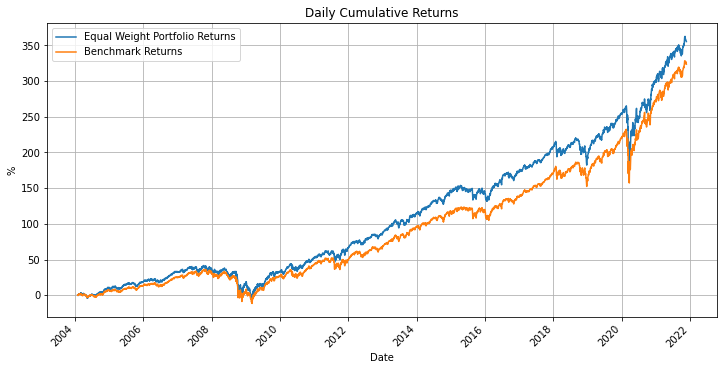

Portfolio Cumulative Returns: 355.39%
Benchmark Cumulative Returns: 323.69%


In [4]:
# get daily returns and change col names
df_pct_change = df_adj_close.pct_change().fillna(0)
df_pct_change.columns = [col.replace(' Adj Close', ' Returns') for col in df_pct_change.columns]

# call it df_D, D for Daily
df_D = df_pct_change

# create an equal weight portfolio that is rebalanced daily @ market close.
df_D['Equal Weight Portfolio Returns'] = df_D[[
    'TLT Returns', 
    'VTI Returns', 
    'VTV Returns', 
    'VBR Returns', 
    'AGG Returns'
]].mean(axis='columns')

# create a 60/40 benchmark to compare portfolio returns against through out analysis.
df_D['Benchmark Returns'] = (
    (0.6 * df_D['VTI Returns']) + (0.4 * df_D['AGG Returns'])
)
# df_D['Benchmark Returns'] = (df_D['SPY Returns'])

# visualize the portfolio v benchmark
(((1+df_D[['Equal Weight Portfolio Returns', 'Benchmark Returns']]).cumprod()-1)*100).plot(
    figsize=(12,6),
    title='Daily Cumulative Returns'
)
plt.ylabel('%')
plt.grid()
plt.xticks(rotation=45)
plt.show()
portfolio_cumulative_return = round(((1+df_D['Equal Weight Portfolio Returns']).cumprod()[-1]-1)*100, 2)
print(f'Portfolio Cumulative Returns: {portfolio_cumulative_return}%')
benchmark_cumulative_return = round(((1+df_D['Benchmark Returns']).cumprod()[-1]-1)*100, 2)
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')

## Drawdown Analysis
---
Here I identify the portfolio's top 5 drawdown periods and provide an underwater visualization of returns.

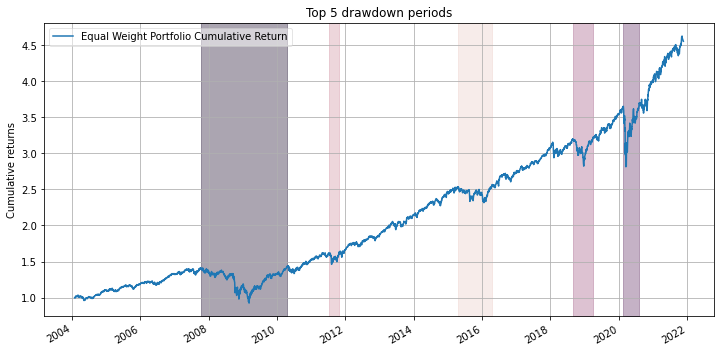

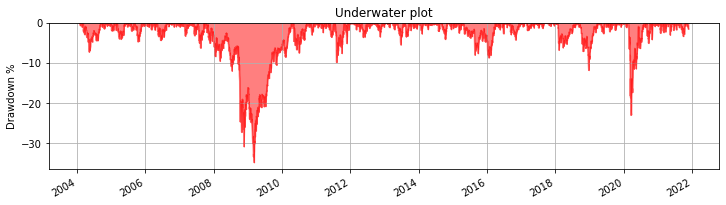

In [5]:
plt_u.plot_drawdown_periods(df_D['Equal Weight Portfolio Returns'])
plt_u.plot_drawdown_underwater(df_D['Equal Weight Portfolio Returns'])

## Construct Bubble Portfolio
---
Is it possible to avoid the large drawdowns discovered in the drawdown analysis? Here we use the [Log-Periodic Power Law Singularity (LPPLS) Model](https://en.wikipedia.org/wiki/Didier_Sornette#The_JLS_and_LPPLS_models). It describes a bubble as a faster-than-exponential increase in asset price that reflects positive feedback loop of higher return anticipations competing with negative feedback spirals of crash expectations. A bubble has a distinct signature that resembles a power law with a finite-time singularity decorated by oscillations with a frequency increasing with time.

If we can identify bubbles in an equity benchmark, perhaps we could use that as a signal to weight our portfolio more heavily towards the less risky debt assets (AGG and TLT).

The first step is to compute the bubble indicators for the benchmark. Here I'm going to find bubbles in the VTI instrument, since it is total market.

In [6]:
# convert Date to ordinal, that's what the LPPLS model wants - it's a neat trick for curve-fitting with time-series
time_ord = [pd.Timestamp.toordinal(t1) for t1 in df_adj_close.index]

# create list of observation data
price = np.log(df_adj_close['VTI Adj Close'].values)

# create observations array (expected format for LPPLS observations)
observations = np.array([time_ord, price])

# set the max number for searches to perform before giving-up
# the literature suggests 25
MAX_SEARCHES = 25

# instantiate a new LPPLS model with the VTI data
lppls_model = lppls.LPPLS(observations=observations)

load LPPLS conf scores from cache


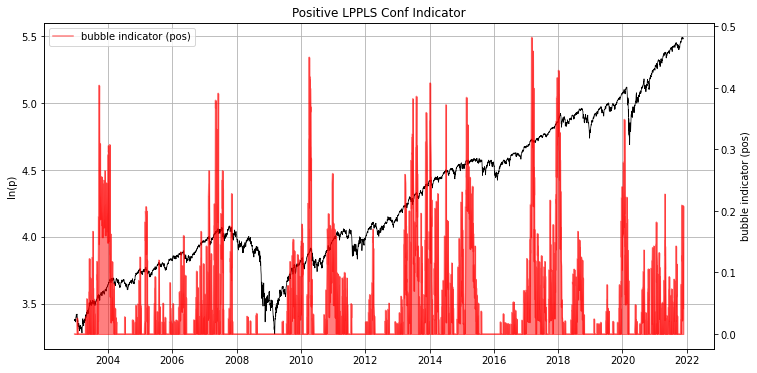

In [7]:
# compute the indicators and cache the result
if not exists(LPPLS_CONF_CSV):
    print('compute LPPLS conf scores fresh')
    # compute the confidence indicator
    res = lppls_model.mp_compute_nested_fits(
        workers=CPU_CORES,
        window_size=126*3, 
        smallest_window_size=21, 
        outer_increment=1, 
        inner_increment=5, 
        max_searches=25,
        # filter_conditions_config={} # not implemented in 0.6.x
    )
    res_df = lppls_model.compute_indicators(res)
    res_df['time'] = [pd.Timestamp.fromordinal(int(t1)) for t1 in res_df['time']]
    res_df.set_index('time', inplace=True)
    res_df.to_csv(LPPLS_CONF_CSV)
else:
    print('load LPPLS conf scores from cache')
    res_df = pd.read_csv(LPPLS_CONF_CSV, index_col='time', parse_dates=True)
    
# visualize the conf indicator   
plt_u.plot_pos_confidence_indicators(res_df)

Next we want to use this info to weight our portfolio. A simple rule could be to reduce equity exposure to 0% across the entire portfolio when the bubble confidence indicator exceeds a threshold.

<ipython-input-8-1ea1082af3d0>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bp_df['Bubble Portfolio Returns'] = np.select(conditions, values)
<ipython-input-8-1ea1082af3d0>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bp_df['Allocation'] = np.select(conditions, ['risk-off', 'equal-weight', 'risk-on'])


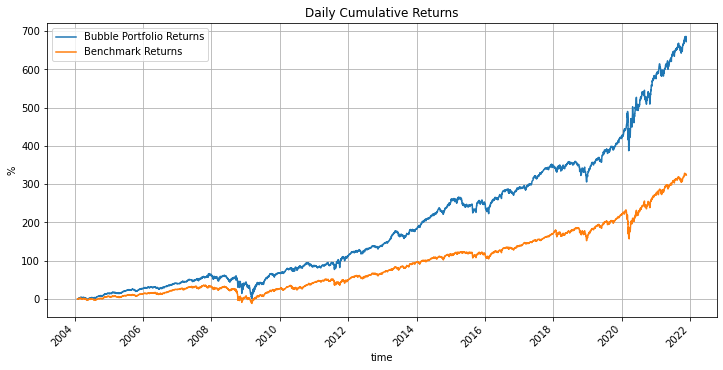

Bubble Portfolio Cumulative Returns: 672.51%
Benchmark Cumulative Returns: 323.69%


In [8]:
pos_conf_df = res_df.drop(['price', '_fits'], axis=1)
bubble_portfolio_df = pos_conf_df.join(df_D)

bubble_portfolio_df['conf'] = bubble_portfolio_df['pos_conf'] - bubble_portfolio_df['neg_conf']

# prevent lookahead bias: use yesterday's conf score today 
bubble_portfolio_df['conf'] = bubble_portfolio_df['conf'].shift(2)
bp_df = bubble_portfolio_df[START:END]
# # group pos_conf by month and take the mean, 
# # @TODO: it would be better to weight most recent observations heavier
# conf_M = bubble_portfolio_df['conf'].groupby(pd.Grouper(freq='M')).mean() 

# # reintegrate monthly data to bubble_portfolio_df and forward fill the indicator, 
# # the previous month's mean pos_conf will determine what we do all next month
# bp_df = bubble_portfolio_df.join(conf_M.rename('conf_M', inplace=True))
# bp_df['conf_M'] = bp_df['conf_M'].fillna(method='ffill').fillna(0)

# construct a new portfolio with bubble weights...
conditions = [
    (bp_df['conf'] >= POS_BUBBLE_THRESHOLD), 
    ((bp_df['conf'] < POS_BUBBLE_THRESHOLD) & (bp_df['conf'] > -NEG_BUBBLE_THRESHOLD)),  
    (bp_df['conf'] <= -NEG_BUBBLE_THRESHOLD)]
values = [
    (   # ⬇️ Risk Off
        (0.0 * bp_df['VTI Returns']) \
        + (0.0 * bp_df['VTV Returns']) \
        + (0.0 * bp_df['VBR Returns']) \
        + (0.5 * bp_df['AGG Returns']) \
        + (0.5 * bp_df['TLT Returns']) \
    ),( # ⬇️ Equal Weight
        (0.2 * bp_df['VTI Returns']) \
        + (0.2 * bp_df['VTV Returns']) \
        + (0.2 * bp_df['VBR Returns']) \
        + (0.2 * bp_df['AGG Returns']) \
        + (0.2 * bp_df['TLT Returns']) \
    ),( # ⬇️ Risk On
        (0.333 * bp_df['VTI Returns']) \
        + (0.333 * bp_df['VTV Returns']) \
        + (0.333 * bp_df['VBR Returns']) \
        + (0.0 * bp_df['AGG Returns']) \
        + (0.0 * bp_df['TLT Returns']) \
    )
]
bp_df['Bubble Portfolio Returns'] = np.select(conditions, values)
bp_df['Allocation'] = np.select(conditions, ['risk-off', 'equal-weight', 'risk-on'])

# visualize the portfolio v benchmark
(((1+bp_df[['Bubble Portfolio Returns', 'Benchmark Returns']]).cumprod()-1)*100).plot(
    figsize=(12,6),
    title='Daily Cumulative Returns'
)
plt.ylabel('%')
plt.grid()
plt.xticks(rotation=45)
plt.show()
portfolio_cumulative_return = round(((1+bp_df['Bubble Portfolio Returns']).cumprod()[-1]-1)*100, 2)
print(f'Bubble Portfolio Cumulative Returns: {portfolio_cumulative_return}%')
benchmark_cumulative_return = round(((1+bp_df['Benchmark Returns']).cumprod()[-1]-1)*100, 2)
print(f'Benchmark Cumulative Returns: {benchmark_cumulative_return}%')

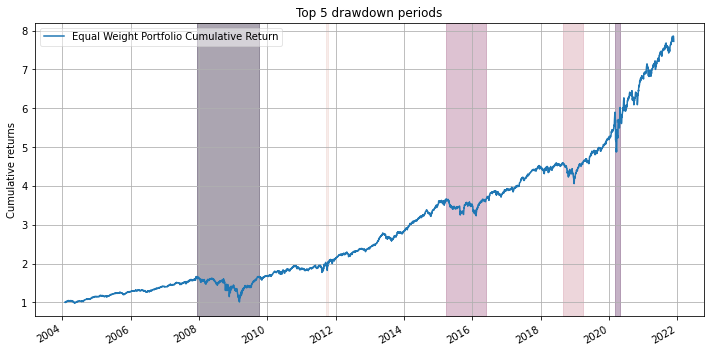

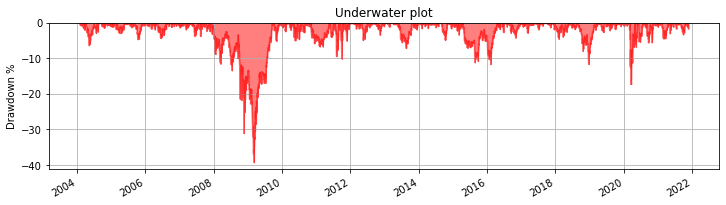

In [9]:
plt_u.plot_drawdown_periods(bp_df['Bubble Portfolio Returns'])
plt_u.plot_drawdown_underwater(bp_df['Bubble Portfolio Returns'])

If we wanted to, we could try to optimize the bubble threshold value by looking at the distribution of values. 

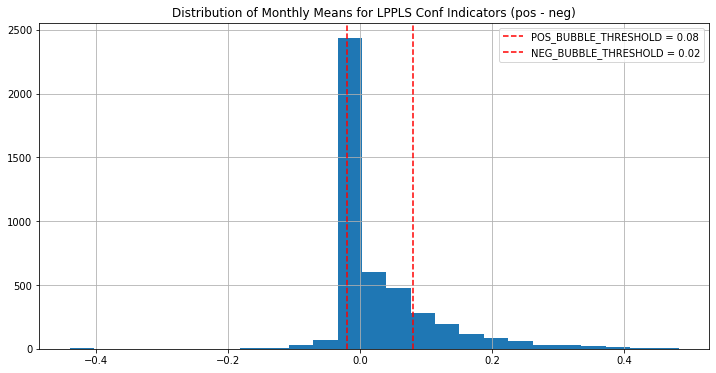

In [10]:
plt.figure(figsize=(12,6))
plt.hist(bp_df['conf'], bins=25)
plt.axvline(POS_BUBBLE_THRESHOLD, color='red', ls='--', label=f'POS_BUBBLE_THRESHOLD = {POS_BUBBLE_THRESHOLD}')
plt.axvline(-NEG_BUBBLE_THRESHOLD, color='red', ls='--', label=f'NEG_BUBBLE_THRESHOLD = {NEG_BUBBLE_THRESHOLD}')
plt.title('Distribution of Monthly Means for LPPLS Conf Indicators (pos - neg)')
plt.legend()
plt.grid()
plt.show()

## Backtest Performance Summary Statistics
---

Below I compute a few performance metrics for the entire backtest period and for a rolling 6 month window.

### Sharpe
$Sharpe = \frac{R_p-R_f}{\sigma_p}$

where

- $R_p=$ return of portfolio
- $R_f=$ risk-free rate
- $\sigma_p=$ standard deviation of the portfolio’s excess return


Equal Weight Portfolio Sharpe Ratio (Since Inception): 0.76
Bubble Portfolio Sharpe Ratio (Since Inception): 0.88


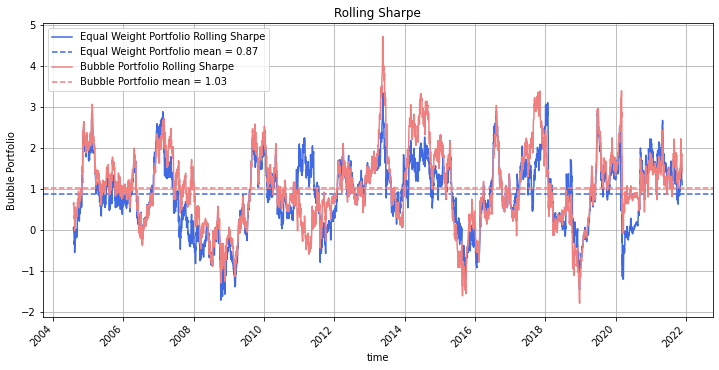

In [11]:
plt_u.plot_sharpe([
    (
        bp_df['Equal Weight Portfolio Returns'], 
        RISK_FREE_RATE, 
        bp_df['Equal Weight Portfolio Returns'].std(), 
        'Equal Weight Portfolio',
        'royalblue',
    ), (
        bp_df['Bubble Portfolio Returns'], 
        RISK_FREE_RATE, 
        bp_df['Bubble Portfolio Returns'].std(), 
        'Bubble Portfolio',
        'lightcoral',
    )
])

### Sortino Ratio

$Sortino = \frac{R_p-R_f}{\sigma_d}$

where
- $R_p=$ return of portfolio
- $R_f=$ risk-free rate
- $\sigma_d=$ standard deviation of the downside 

Equal Weight Portfolio Sortino Ratio (Since Inception): 0.93
Bubble Portfolio Sortino Ratio (Since Inception): 1.05


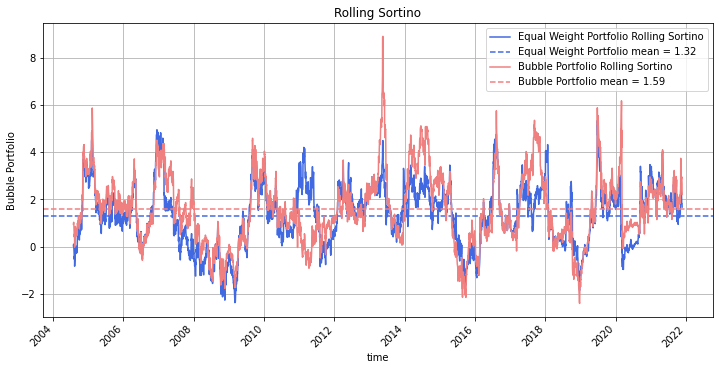

In [12]:
plt_u.plot_sortino([
    (
        bp_df['Equal Weight Portfolio Returns'],
        RISK_FREE_RATE,
        (df_D['Equal Weight Portfolio Returns'][df_D['Equal Weight Portfolio Returns'] < 0]),
        'Equal Weight Portfolio',
        'royalblue',
    ),
    (
        bp_df['Bubble Portfolio Returns'],
        RISK_FREE_RATE,
        (bp_df['Bubble Portfolio Returns'][bp_df['Bubble Portfolio Returns'] < 0]),
        'Bubble Portfolio',
        'lightcoral'
    )
])

### Information Ratio

$IR = \frac{R_p-R_b}{\sigma_p}$

where
- $R_p=$ return of portfolio
- $R_b=$ return of a benchmark portfolio
- $\sigma_p=$ standard deviation of the portfolio’s excess return

Equal Weight Portfolio Information Ratio (Since Inception): 0.13
Bubble Portfolio Information Ratio (Since Inception): 0.51


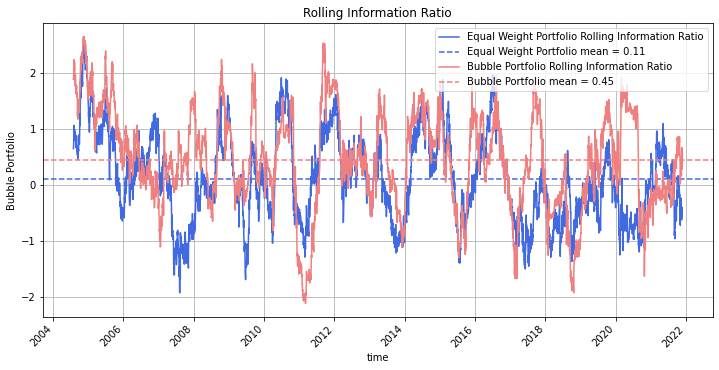

In [13]:
plt_u.plot_ir([
    (
        df_D['Equal Weight Portfolio Returns'],
        df_D['Benchmark Returns'],
        'Equal Weight Portfolio',
        'royalblue',
    ),
    (
        bp_df['Bubble Portfolio Returns'],
        df_D['Benchmark Returns'],
        'Bubble Portfolio',
        'lightcoral'
    )
])

### Beta

$\beta = \frac{Cov(R_p, R_b)}{Var(R_m)}$

where
- $R_p=$ return of portfolio
- $R_b=$ return of a benchmark portfolio

Equal Weight Portfolio Beta (Since Inception): 0.96
Bubble Portfolio Beta (Since Inception): 1.01


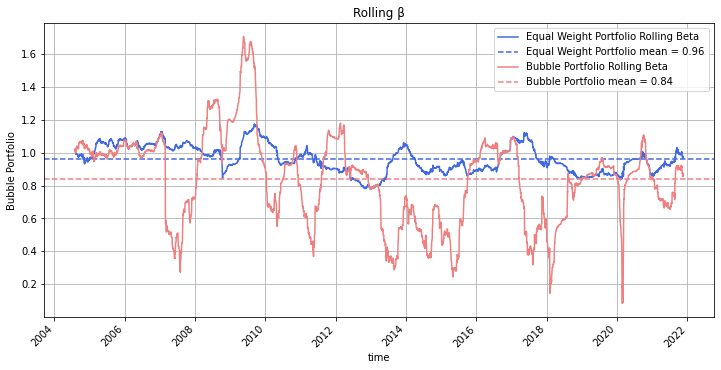

In [14]:
plt_u.plot_beta([
    (
        df_D[['Equal Weight Portfolio Returns', 'Benchmark Returns']],
        df_D['Equal Weight Portfolio Returns'],
        df_D['Benchmark Returns'],
        'Equal Weight Portfolio',
        'royalblue'
    ),
    (
        bp_df[['Bubble Portfolio Returns', 'Benchmark Returns']],
        bp_df['Bubble Portfolio Returns'],
        bp_df['Benchmark Returns'],
        'Bubble Portfolio',
        'lightcoral'
    )
])

## Conclusion
This methodology could be used in conjunction with various asset allocation models. It effictively avoids large markets drawdowns. You should incorporate it in your fund or portfolio, hmu.

In [15]:
print(len(bp_df[bp_df['Allocation']=='equal-weight']))
print(len(bp_df[bp_df['Allocation']=='risk-off']))
print(len(bp_df[bp_df['Allocation']=='risk-on']))

3456
838
193
